# Polarization example (GRB) - azimuthal scattering angle distribution (ASAD) method

This notebook fits the polarization fraction and angle of a GRB simulated using MEGAlib and combined with background. It's assumed that the start time, duration, localization, and spectrum of the GRB are already known. The GRB was simulated with 70% polarization at an angle of 110 degrees in the RelativeX convention, which corresponds to 83.015 degrees in the IAU convention.

The data to run this notebook, including GRBs simulated on-axis, 10 degrees off-axis, and 20 degrees off-axis, can be found on the COSI Pipeline Google Drive: https://drive.google.com/drive/folders/1kCkqQv07APSSlexeuIgK2Jj7eqJzNNgQ. However, with the RelativeZ response, it is not possible to fit the on-axis GRB.

Caveats/limitations:
- Currently, the source must be stationary with respect to the instrument, and the spacecraft must be stationary. The ability to fit the polarization of persistent sources will be added later. 
- The background simulation is used as the background model, and its ASAD is subtracted from the source+background ASAD.   

In [1]:
from cosipy import UnBinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.polarization.conventions import MEGAlibRelativeX, MEGAlibRelativeY, MEGAlibRelativeZ, IAUPolarizationConvention
from cosipy.polarization.polarization_asad import PolarizationASAD, calculate_uncertainties
from cosipy.polarization.polarization_stokes import PolarizationStokes

from cosipy.threeml.custom_functions import Band_Eflux
from astropy.time import Time
import numpy as np
from astropy.coordinates import Angle, SkyCoord
from astropy import units as u
from scoords import SpacecraftFrame
from scipy.optimize import curve_fit

22:45:10 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=533190;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=861861;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=174233;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=75480;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=645613;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=101305;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

         INFO      Starting 3ML!                                                                     ]8;id=656616;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=106640;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#39\39]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=10275;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=845848;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=884194;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=398259;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#41\41]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=408112;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=819623;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#44\44]8;;\

22:45:10 WARNING   ROOT minimizer not available                                                ]8;id=495983;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=232609;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=662022;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=512349;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=755205;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=374924;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=324886;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=359536;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=29089;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=122223;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=549308;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=241326;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

22:45:11 WARNING   No fermitools installed                                              ]8;id=66660;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=824640;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

22:45:11 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=113226;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=698079;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=856134;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=669028;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=800978;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=295554;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

Read in the data (GRB+background), background simulation, and define the path to the detector response

In [2]:
path = '/Users/mnegro/MyDocuments/_COSI/COSIpy/eliza_pull_request/eliza_data/'
analysis = UnBinnedData(path+'grb.yaml') # e.g. grb.yaml

analysis.select_data(unbinned_data=path+'GRB_20_0.hdf5', output_name=path+'GRB_20_0_selected.hdf5') # e.g. GRB_20_0.hdf5 & GRB_20_0_selected.hdf5
grb_data = analysis.get_dict_from_hdf5(path+'GRB_20_0_selected.hdf5') # e.g. GRB_20_0_selected.hdf5
background = analysis.get_dict_from_hdf5(path+'background.hdf5') # e.g. background.hdf5

response_file = path+'RelativeZ_200to500keV_1ebins_12pbins_log_flat.binnedpolarization.11D_nside8.h5' # e.g. HEALPixO3_200to500keV_1ebins_12pbins_log_flat.binnedpolarization.11D_nside8.area.h5

Read in the orientation file. Here, the spacecraft is stationary, so we are only using the first attitude bin

In [3]:
sc_orientation = SpacecraftFile.parse_from_file(path+'ori.ori') # e.g. ori.ori
sc_orientation = sc_orientation.source_interval(Time(analysis.tmin,format = 'unix'), Time(analysis.tmax,format = 'unix'))

attitude = sc_orientation.get_attitude()[0]

Define the GRB spectrum. This is convolved with the response to calculate the ASADs of an unpolarized and 100% polarized source

In [4]:
a = 10. * u.keV
b = 5000. * u.keV
alpha = 0.880
beta = -2.384
ebreak = 195.613 * u.keV
K = 10. / u.cm / u.cm / u.s

spectrum = Band_Eflux(a = a.value,
                      b = b.value,
                      alpha = alpha,
                      beta = beta,
                      E0 = ebreak.value,
                      K = K.value)

spectrum.a.unit = a.unit
spectrum.b.unit = b.unit
spectrum.E0.unit = ebreak.unit
spectrum.K.unit = K.unit

Define the source position and polarization object

In [5]:
source_direction = SkyCoord(0, 70, representation_type='spherical', frame=SpacecraftFrame(attitude=attitude), unit=u.deg)
source_photons = PolarizationStokes(source_direction, spectrum, response_file, sc_orientation)
az_ang = source_photons.calculate_azimuthal_scattering_angles(grb_data)

This class loading takes around 30 seconds... 



Calculate the Pseudo Stokes parameters from the scattering angle for each photon in the data and background simulation

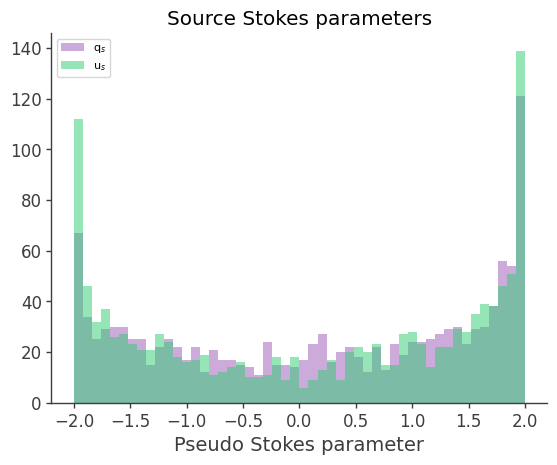

In [7]:
qs, us = source_photons.compute_pseudo_stokes(az_ang, show=True)
np.save('qs.npy', qs)
np.save('us.npy', us)

this task takes around 25 seconds...

Creating the unpolarized ASAD...
random_values [0.7020638  0.94086807 0.15846523 ... 0.82078006 0.62674554 0.73505378]
unpol_azimuthal_angles [ 0.98720613  2.44752417 -2.23587581 ...  1.79036498  0.57494522
  1.1694967 ] rad


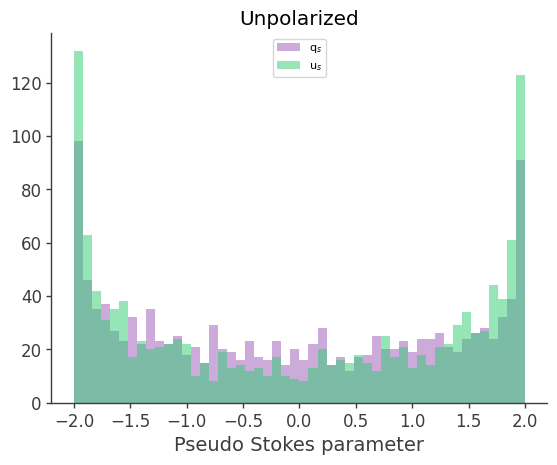

In [9]:
unpol_qs, unpol_us = source_photons.create_unpolarized_pseudo_stokes(len(az_ang), show=True)
np.save('unpol_qs.npy', unpol_qs)
np.save('unpol_us.npy', unpol_us)

This task takes a couple of minutes to run... hold on...

Creating the 100% polarized ASAD...
Creating the unpolarized ASAD...
A = 0.69, B = 0.64, C = 1.45
Rmax, Rmin: 1.3255857147752785 0.6913840315477051
Modulation mu =  0.3144329181851877
A = 0.69, B = 0.63, C = 1.19
Rmax, Rmin: 1.3213195967353855 0.6937372845666253
Modulation mu =  0.31144644996981596
A = 0.70, B = 0.61, C = 0.93
Rmax, Rmin: 1.3076701330552678 0.6963055633549808
Modulation mu =  0.30507584038840063
A = 0.69, B = 0.62, C = 0.65
Rmax, Rmin: 1.3069797694176002 0.6945917997702361
Modulation mu =  0.3059535712209624
A = 0.69, B = 0.62, C = 0.38
Rmax, Rmin: 1.3007442567023138 0.6875203963372963
Modulation mu =  0.30842164770546815
A = 0.68, B = 0.63, C = 3.27
Rmax, Rmin: 1.305323631848115 0.6799280138066874
Modulation mu =  0.3150208284225606
A = 1.31, B = -0.63, C = 1.44
Rmax, Rmin: 1.3072674636919108 0.6759601874055354
Modulation mu =  0.3183231516245918
A = 1.31, B = -0.63, C = 1.19
Rmax, Rmin: 1.3044063659899097 0.68

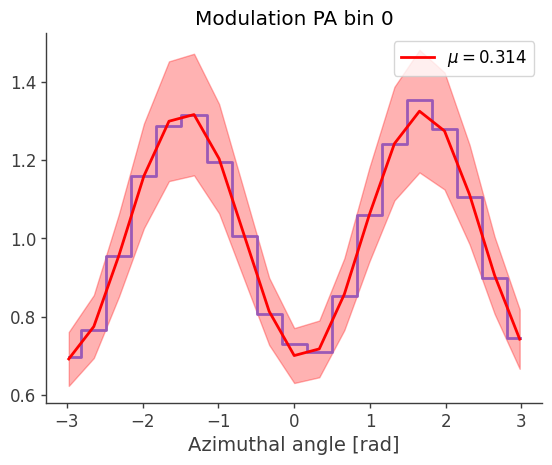

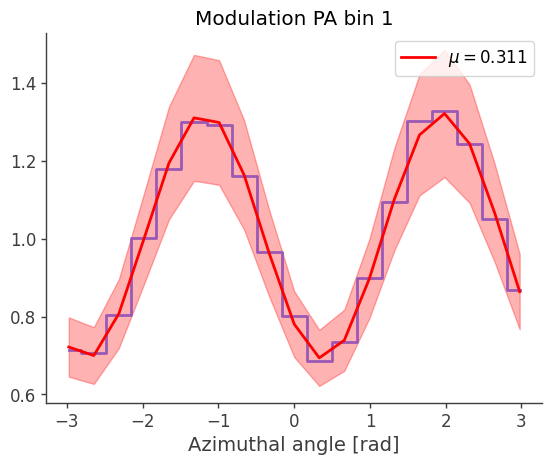

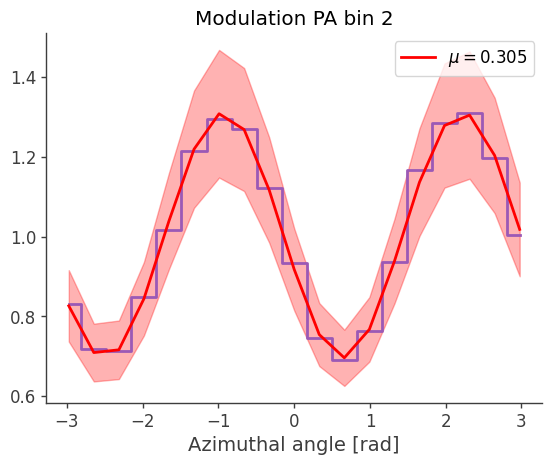

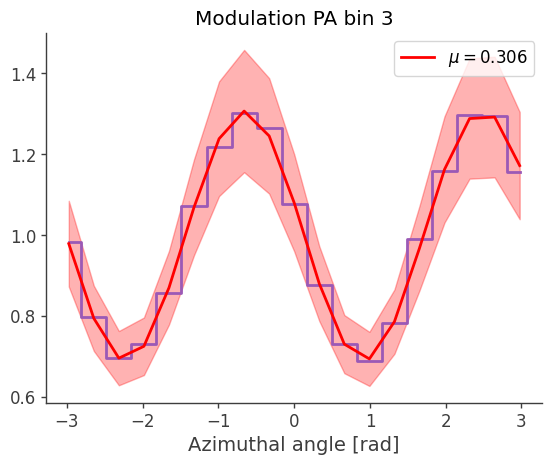

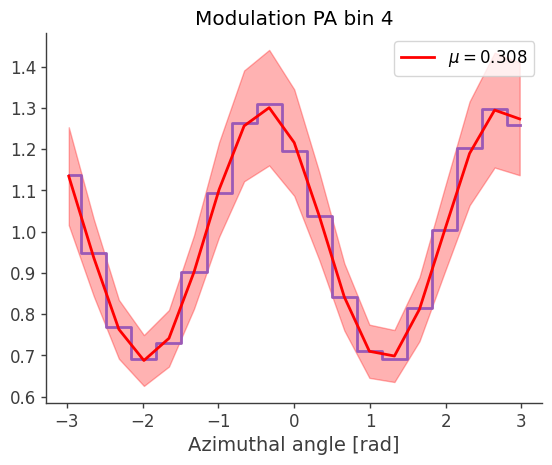

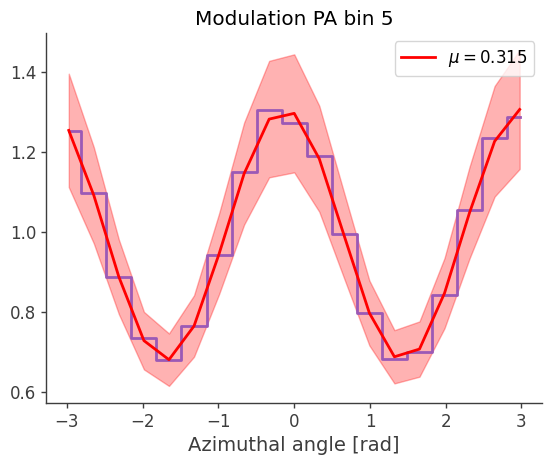

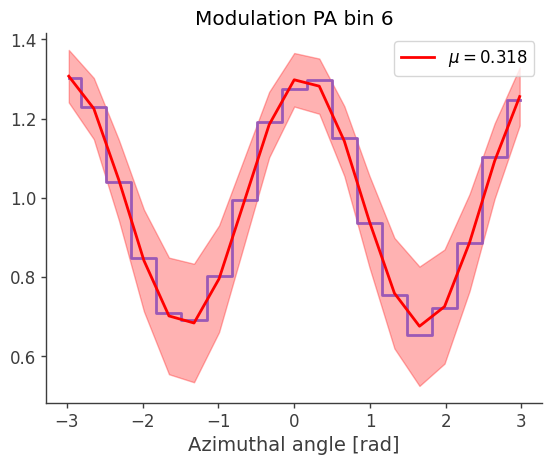

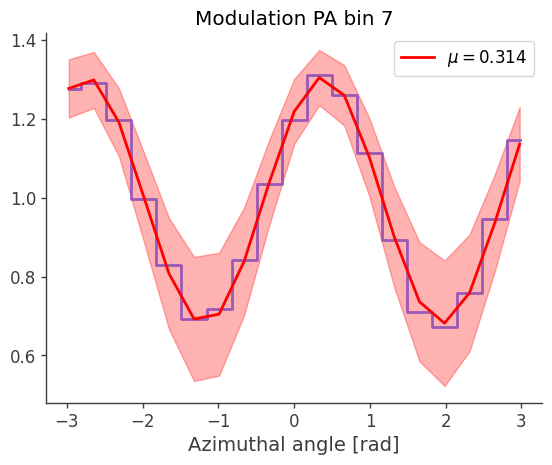

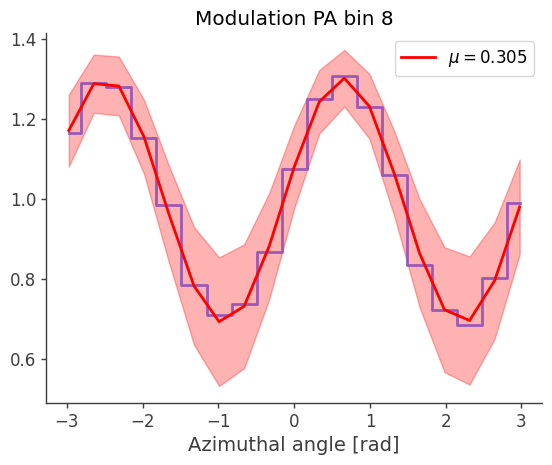

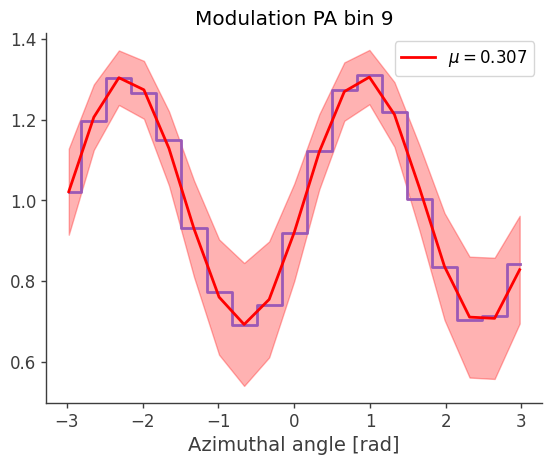

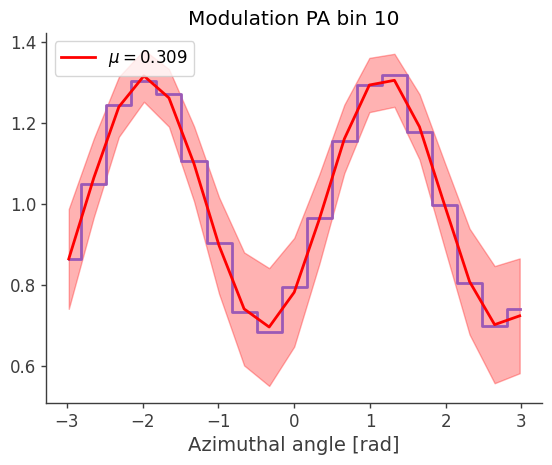

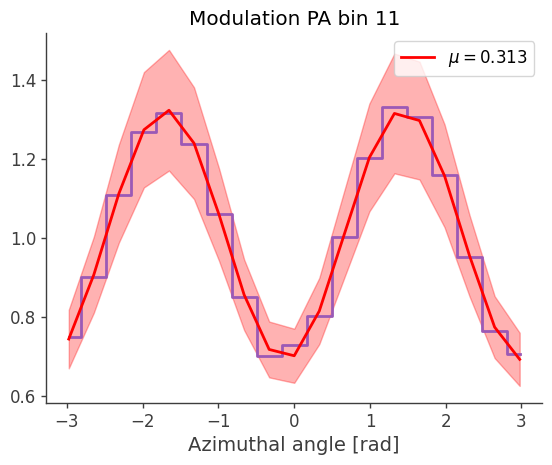

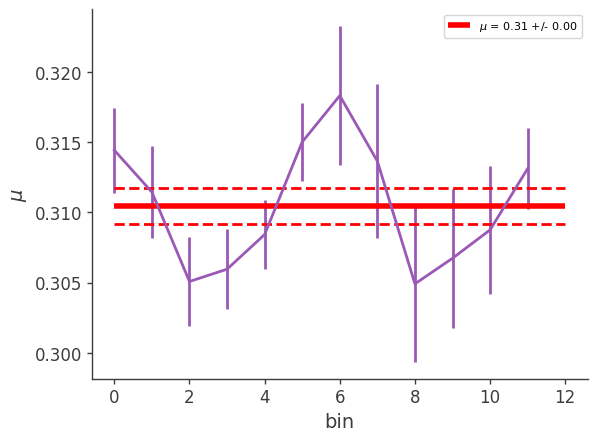

In [10]:
mu, mu_err = source_photons.calculate_mu(bins=20, show=True)


Create an azimuthal scattering angle distribution (ASAD) each for the data and background simulation

modularion factor: 0.31048713272678163 +/- 0.0012843969646897993
-------  Q/I, U/I -0.28751326582102654 0.8931376011806802
PD: 0.9382742950043191 +/- 0.12342890897514582
PA 76.82040325366 +/- 3.8511941530269103


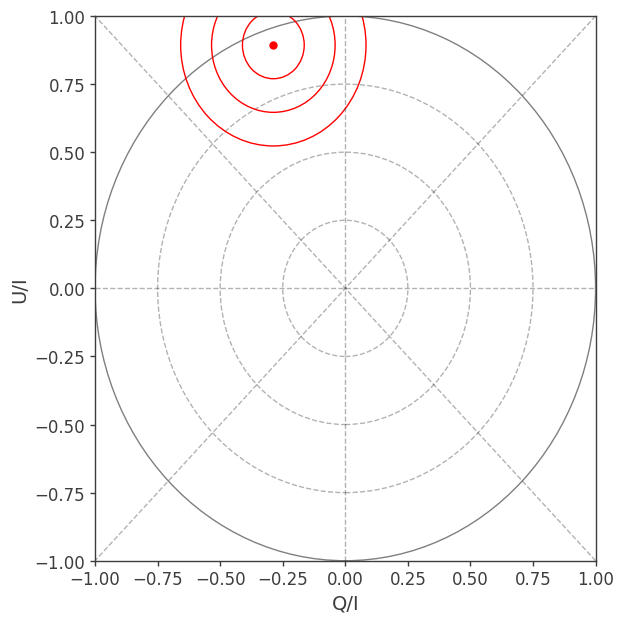

loading files...
Simulated PD, PA: 70%, 83 degrees E of N
Simulated Q/I, U/I: -0.2, 0.7
0.9382742950043191 0.12342890897514582 1.34077 rad 3.8511941530269103


In [12]:
print('modularion factor:', mu, '+/-', mu_err)
PD, PD_err, PA, PA_err = source_photons.calculate_polarization(qs, us, unpol_qs, unpol_us, mu, show=True)

print('loading files...')
print('Simulated PD, PA: 70%, 83 degrees E of N')
sim_pd, sim_pa = 0.7, np.radians(83)
sim_u = sim_pd / np.sqrt((np.tan(2*sim_pa))**2 + 1)
sim_q = sim_pd / np.sqrt((np.tan(2*sim_pa))**2 + 1) * np.tan(2*sim_pa)
print('Simulated Q/I, U/I: %.1f, %.1f'%(sim_q, sim_u))

print(PD, PD_err, PA, PA_err)


Transform polarization angle to different conventions

In [ ]:
print('RelativeX:', round(polarization['angle'].transform_to(MEGAlibRelativeX(attitude=attitude)).angle.degree, 3), 'degrees')
print('RelativeY:', round(polarization['angle'].transform_to(MEGAlibRelativeY(attitude=attitude)).angle.degree, 3), 'degrees')
print('RelativeZ:', round(polarization['angle'].transform_to(MEGAlibRelativeZ(attitude=attitude)).angle.degree, 3), 'degrees')
print('IAU:', round(polarization['angle'].transform_to(IAUPolarizationConvention()).angle.degree, 3), 'degrees')